In [17]:
import pandas as pd
import numpy as np
import fasttext
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

In [18]:
dataset = pd.read_csv('amazon_reviews.csv')
print(dataset.head())

   Unnamed: 0  reviewerName  overall  \
0           0           NaN        4   
1           1          0mie        5   
2           2           1K3        4   
3           3           1m2        5   
4           4  2&amp;1/2Men        5   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  23-07-2014       138   
1  Purchased this for my device, it worked as adv...  25-10-2013       409   
2  it works as expected. I should have sprung for...  23-12-2012       715   
3  This think has worked out great.Had a diff. br...  21-11-2013       382   
4  Bought it with Retail Packaging, arrived legit...  13-07-2013       513   

   helpful_yes  helpful_no  total_vote  score_pos_neg_diff  \
0            0           0           0                   0   
1            0           0           0                   0   
2            0           0           0                   0   
3            0           0           0    

In [19]:
# Define a function for preprocessing text
def preprocess_text(text):
    # Remove punctuation and digits
    text = re.sub(r'[^\w\s]', '', str(text))
    text = re.sub(r'\d+', '', text)
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the lemmatized tokens back into a single string
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

# Preprocess the 'reviewText' column
dataset['reviewText'] = dataset['reviewText'].apply(preprocess_text)





dataset = dataset.dropna(subset=['reviewText'])

reviews = dataset['reviewText']

filename = 'reviews.txt'

if (os.path.isfile(filename) == 0):
    # Extract the reviewText column
    reviews = dataset['reviewText']

    # Write the reviews to a text file
    with open('reviews.txt', 'w+', encoding='utf-8') as f:
        for review in reviews:
            f.write(review + '\n')

In [20]:
import pandas as pd
import fasttext

# Load the dataset
dataset = pd.read_csv('amazon_reviews.csv')

# Fetch the data from the 'reviewText' and 'label' columns
X = dataset['reviewText']
y = dataset['label']

# Split the dataset into training and testing sets with a 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert X_train to strings to handle missing values
X_train = X_train.astype(str)

# Write the training and testing data to separate text files
with open('train.txt', 'w') as f:
    for review in X_train:
        f.write(review + '\n')
        
with open('test.txt', 'w') as f:
    for review in X_test:
        f.write(review + '\n')

# Train a FastText model on the training data
model = fasttext.train_unsupervised('train.txt', dim=100)

# Generate vectors for the training data
train_vectors = []
for review in X_train:
    vector = model.get_sentence_vector(review)
    train_vectors.append(vector)

# Generate vectors for the testing data
test_vectors = []
for review in X_test:
    vector = model.get_sentence_vector(review)
    test_vectors.append(vector)

# Print the number of training and testing samples
print(f'Training data size: {len(train_vectors)}')
print(f'Testing data size: {len(test_vectors)}')

# Print the first 10 training and testing vectors
print(train_vectors[:10])
print(test_vectors[:10])


Training data size: 3932
Testing data size: 983
[array([ 0.22494082,  0.01274331,  0.08287989, -0.01812015,  0.03784227,
        0.03536929, -0.00922814, -0.01045823, -0.05644022,  0.00952157,
       -0.16674316,  0.0262158 , -0.06257476, -0.21215323, -0.00236902,
       -0.11904086, -0.18183327,  0.00651616,  0.13338247, -0.04562911,
        0.01553588,  0.02943993,  0.05896488, -0.03127388, -0.02820554,
        0.08361573, -0.09956519,  0.06122924, -0.13863625,  0.06471318,
       -0.03658034,  0.06052412, -0.0240916 , -0.18391567, -0.09840707,
       -0.15761013, -0.01097521, -0.00566115,  0.05645594,  0.00360052,
        0.04187746,  0.15024844,  0.01207746, -0.02972422,  0.03856194,
       -0.15271196, -0.03818887, -0.07688609, -0.03861349,  0.02120102,
       -0.06186369, -0.00113614, -0.02702796, -0.1579136 , -0.02456899,
        0.03271464, -0.10725467,  0.12226203,  0.07462747, -0.07977069,
        0.01213781,  0.15472339, -0.00189753,  0.08588753,  0.1877669 ,
       -0.02208

In [21]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Convert train_vectors to a numpy array
train_vectors = np.array(train_vectors)

# Define the input shape for the model
input_shape = (train_vectors.shape[1], 1)

# Create a Sequential model
model = Sequential()

# Add a 1D convolutional layer with 32 filters and a filter size of 3
model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))

# Add a max pooling layer
model.add(MaxPooling1D(3))

# Add a 1D convolutional layer with 64 filters and a filter size of 3
model.add(Conv1D(64, 3, activation='relu'))

# Add a global max pooling layer
model.add(GlobalMaxPooling1D())

# Add a dropout layer for regularization
model.add(Dropout(0.5))

# Add a dense output layer with a sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model to the training data
model.fit(train_vectors, y_train, epochs=10, batch_size=32, validation_split=0.2)

model.summary()

Epoch 1/10
99/99 [==============================] - 2s 8ms/step - loss: 0.5840 - accuracy: 0.8452 - val_loss: nan - val_accuracy: 0.8374
Epoch 2/10
99/99 [==============================] - 1s 5ms/step - loss: 0.5581 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 3/10
99/99 [==============================] - 1s 6ms/step - loss: 0.5575 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 4/10
99/99 [==============================] - 1s 5ms/step - loss: 0.5557 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 5/10
99/99 [==============================] - 1s 6ms/step - loss: 0.5530 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 6/10
99/99 [==============================] - 0s 5ms/step - loss: 0.5536 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 7/10
99/99 [==============================] - 0s 4ms/step - loss: 0.5584 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 8/10
99/99 [=======================

In [22]:
# Reshape the training data
train_vectors = np.array(train_vectors).reshape(len(train_vectors), len(train_vectors[0]), 1)

# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_vectors, y_train, verbose=0)

# Print the training accuracy
print(f'Training accuracy: {train_accuracy:.2f}')


Training accuracy: 0.85


In [23]:
# Reshape the testing data
test_vectors = np.array(test_vectors).reshape(len(test_vectors), len(test_vectors[0]), 1)

# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(test_vectors, y_test, verbose=0)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy:.2f}')


Test accuracy: 0.84


In [24]:
import numpy as np

# Reshape the testing data
test_vectors = np.array(test_vectors).reshape(len(test_vectors), len(test_vectors[0]), 1)

# Generate predictions on the testing data
y_pred = model.predict(test_vectors)

# Round the predictions to 0 or 1
y_pred_rounded = np.round(y_pred)

# Print the first 10 predictions and actual labels
print('Predictions:', y_pred_rounded[:10])
print('Actual Labels:', y_test[:10])

# Save the predictions to a CSV file
predictions = pd.DataFrame({'predicted_label': y_pred_rounded[:, 0], 'actual_label': y_test})
predictions.to_csv('predictions.csv', index=False)


31/31 [==============================] - 0s 2ms/step
Predictions: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
Actual Labels: 2346    1.0
4344    1.0
691    -1.0
3910    1.0
2487    1.0
79      1.0
2602    1.0
2700    1.0
2208    1.0
3473   -1.0
Name: label, dtype: float64


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Reshape the training data
train_vectors = np.array(train_vectors).reshape(len(train_vectors), len(train_vectors[0]), 1)

# Reshape the testing data
test_vectors = np.array(test_vectors).reshape(len(test_vectors), len(test_vectors[0]), 1)

# Make predictions on the testing data
y_pred = model.predict(test_vectors)

# Convert predicted probabilities to binary labels
y_pred = np.round(y_pred)

# Calculate precision, recall, and F1-score for the testing data
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1score = f1_score(y_test, y_pred, average='weighted')

# Print the results
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1score))

31/31 [==============================] - 0s 2ms/step
Precision: 0.71
Recall: 0.84
F1-score: 0.77


c:\users\rishabh pandey\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
99/99 [==============================] - 1s 7ms/step - loss: 0.5527 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 2/10
99/99 [==============================] - 1s 6ms/step - loss: 0.5482 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 3/10
99/99 [==============================] - 1s 6ms/step - loss: 0.5472 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 4/10
99/99 [==============================] - 1s 5ms/step - loss: 0.5483 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 5/10
99/99 [==============================] - 1s 6ms/step - loss: 0.5446 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 6/10
99/99 [==============================] - 1s 6ms/step - loss: 0.5446 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 7/10
99/99 [==============================] - 1s 6ms/step - loss: 0.5401 - accuracy: 0.8512 - val_loss: nan - val_accuracy: 0.8374
Epoch 8/10
99/99 [=======================

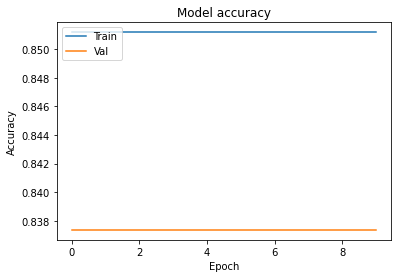

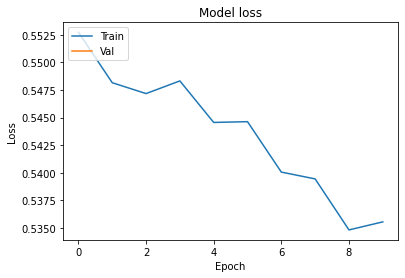

In [33]:
# Fit the model to the training data and store the training history
history = model.fit(train_vectors, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Plot the training and validation accuracy over time
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot the training and validation loss over time
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


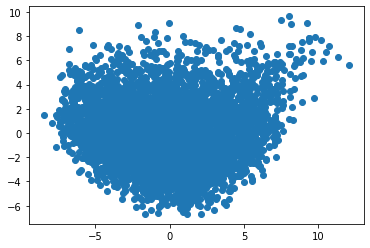

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# Load the pre-trained model
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# Load the data
data = pd.read_csv('amazon_reviews.csv')

# Get the embeddings for the text data
train_vectors = model.encode(data['reviewText'].values)

# Use PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=2)
train_vectors_pca = pca.fit_transform(train_vectors)

# Plot the embeddings
plt.scatter(train_vectors_pca[:, 0], train_vectors_pca[:, 1])
plt.show()
